# Gurobi with CUDA

We will briefly show how to install Gurobi and CUDA in Windows Subsystem for Linux (WSL).

First install Gurobi for Python 3.10 to 3.14t (the "t" is the non-GIL Python version, which is true multi-threading).

![alt text](<images/Screenshot 2026-01-24 192456.png>)

Then, install the CUDA Toolkit for the respective Gurobi installation.

![alt text](<images/Screenshot 2026-01-24 192529.png>)

Installing Gurobi on a Linux WSL machine is a pain, due to requiring a academic VPN.  There is a bug which connecting with the school's VPN will disable the internet on the WSL system.  However, there are workaround for it on the internet.  Luckily, you can also create multiple licenses (one for Windows, and one for WSL).

We verify the installation of the Linux x64, the Python version, a virtual environment for our Python, and installation of the gurobipy:

In [ ]:
uname -m
# Output MUST be: x86_64

python3 --version
# Output MUST be: Python 3.14.x

# 1. Create a virtual environment named 'gurobi_env'
python3.14 -m venv gurobi_env

# 2. Activate the environment
source gurobi_env/bin/activate

# Upgrade pip to ensure it can parse the latest wheel tags
pip install --upgrade pip

# Install the specific wheel file
# Replace /path/to/ with the actual location of your file
pip install gurobipy-13.0.1+cu131-cp314-cp314-manylinux_2_24_x86_64.whl

mv gurobipy-13.0.1+cu131-cp314-cp314-manylinux_2_24_x86_64.whl gurobipy-13.0.1+cu131-cp314-cp314-linux_x86_64.whl
pip install gurobipy-13.0.1+cu131-cp314-cp314-linux_x86_64.whl


We test the installation by running Gurobi in Python:

In [1]:
import gurobipy as gp

# Check version
print(f"Gurobi Version: {gp.gurobi.version()}")

# Create a simple model to test license validity
try:
    m = gp.Model("test")
    m.optimize()
    print("License and Solver validation: SUCCESS")
except gp.GurobiError as e:
    print(f"Error: {e}")

Gurobi Version: (13, 0, 1)
Set parameter Username
Set parameter LicenseID to value 2769789
Academic license - for non-commercial use only - expires 2027-01-25
Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (linux64gpu - "Ubuntu 22.04.5 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

GPU model: NVIDIA GeForce RTX 4090, CUDA compute version 8.9, NVIDIA driver compatible with CUDA version 13

Optimize a model with 0 rows, 0 columns and 0 nonzeros (Min)
Model fingerprint: 0xf9715da1
Model has 0 linear objective coefficients
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

So

Now that it is working, lets run a real application.

Gurobi using CUDA primarily leverages CUDA for the **Barrier Algorithm** when solving Large-Scale Programs (LP) or Quadratic Programs (QP) with dense constraint matrices.  In the context of Barrier method (Interior Point Method), the solver must calculate the Newton step at each iteration.  This involves a large linear system of equations involving the Hessian matrix.

For the QP problem:

$$
\mathrm{minimize} \space f(\boldsymbol{x}) \frac{1}{2} \boldsymbol{x}^T \mathcal{Q} \boldsymbol{x} + c^T \boldsymbol{x}
$$
$$
\mathrm{subject\ to} \  A \boldsymbol{x} = \boldsymbol{b}, \ x \ge 0
$$

where:

- $x \in \mathbb{R}^n$ is the decision vector.
- $\mathcal{Q} \in \mathbb{R}^{n \times n}$ is the positive-semidefinite Hessian matrix.
- $A \in \mathcal{m \times n}$ is the constraint matrix.

The Derivative and Newton Step: To find the search direction $\nabla \boldsymbol{x}$, the algorithm solves the KKT system. The core computational burden lies in forming and factoring the coefficient matrix for the normal equations. The gradient of the objective function is:

$$\nabla f(x) = \mathcal{Q} \boldsymbol{x} + c$$

The Hessian is constant:

$$\nabla^2 f(x) = \mathcal{Q}$$

In the Barrier method, we effectively solve a system of the form:

$$(A \Theta A^T) \nabla y = \mathrm{residual}$$

Where $\Theta$ is a diagonal scaling matrix derived from the current iterate $\boldsymbol{x}$ and dual slacks. When $A$ or $\mathcal{Q}$ are dense, the matrix-matrix multiplication $A \Theta A^T$ and the subsequent Cholesky factorization are heavily floating-point intensive ($O(n^3)$), making them ideal candidates for CUDA acceleration.

Python Implementation

The following script sets up a synthetic Dense Portfolio Optimization problem.

- Vectorization: We use `numpy` to generate dense matrices.

- Solver: We strictly select `Method=2` (Barrier) which is the only method that benefits from GPU offloading in Gurobi.

Generating dense data for 5000 assets...

Starting Optimization...

Optimization converged in 26.8214 seconds.
Optimal Objective Value: 3.3006e-05


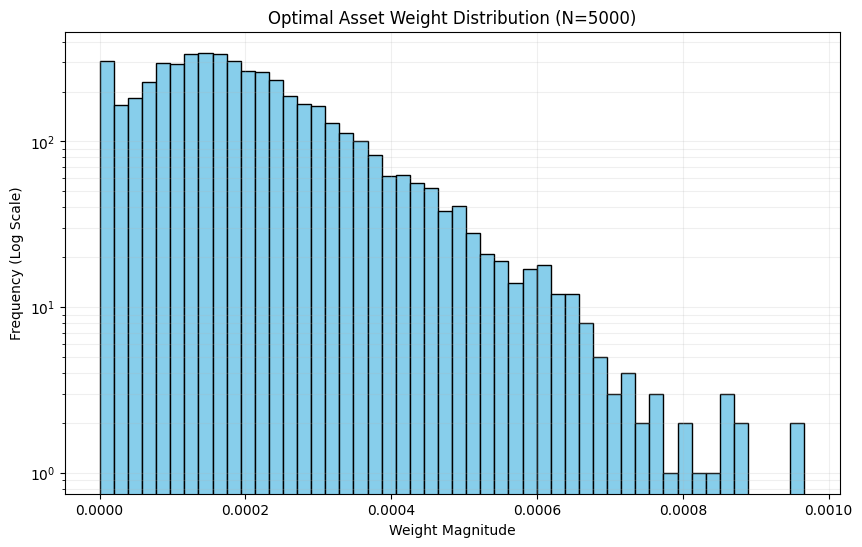

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import time

def solve_dense_qp_cuda(n_assets=5000, seed=42):
    """
    Solves a dense Mean-Variance Portfolio Optimization problem.
    Min (1/2) x^T Q x
    s.t. sum(x) = 1, x >= 0
    """
    # 1. Data Generation (Vectorized)
    # We generate a valid positive-semidefinite Covariance Matrix Q
    print(f"Generating dense data for {n_assets} assets...")
    rng = np.random.default_rng(seed)

    # Create a random factor matrix F (rank-deficient to simulate correlations)
    n_factors = int(n_assets * 0.2)
    F = rng.standard_normal((n_assets, n_factors))

    # Q = FF^T + D (where D is diagonal noise for full rank/stability)
    # This ensures Q is Positive Semidefinite (PSD)
    D = np.diag(rng.uniform(0.1, 0.5, n_assets))
    Q = F @ F.T + D  # Dense Matrix Multiplication

    # 2. Model Setup
    # Use the Matrix API for efficiency with numpy arrays
    env = gp.Env(empty=True)
    env.setParam("OutputFlag", 0)
    env.start()

    m = gp.Model("Dense_QP_CUDA", env=env)

    # Add matrix variables
    x = m.addMVar(shape=n_assets, lb=0.0, ub=1.0, name="weights")

    # 3. Objective: Minimize Risk (Variance)
    # (1/2) x^T Q x
    m.setObjective(0.5 * x @ Q @ x, GRB.MINIMIZE)

    # 4. Constraint: Fully invested budget
    # sum(x) = 1  ->  ones^T * x = 1
    ones = np.ones(n_assets)
    m.addConstr(ones @ x == 1.0, name="budget")

    # 5. GPU Configuration
    # Method=2 forces the Barrier algorithm.
    # While Gurobi often auto-detects, explicit settings help benchmarks.
    m.setParam("Method", 2)

    print("\nStarting Optimization...")
    start_time = time.time()
    m.optimize()
    end_time = time.time()

    # 6. Post-Processing & Plotting
    if m.Status == GRB.OPTIMAL:
        sol = x.X
        print(f"\nOptimization converged in {end_time - start_time:.4f} seconds.")
        print(f"Optimal Objective Value: {m.ObjVal:.4e}")

        # Plotting the asset weight distribution
        plt.figure(figsize=(10, 6))
        plt.hist(sol, bins=50, log=True, color='skyblue', edgecolor='black')
        plt.title(f'Optimal Asset Weight Distribution (N={n_assets})')
        plt.xlabel('Weight Magnitude')
        plt.ylabel('Frequency (Log Scale)')
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.show()
    else:
        print("Optimization was unsuccessful.")

if __name__ == "__main__":
    solve_dense_qp_cuda()

Why this benefits from CUDA

1. Dense Q: In the code `Q = F @ F.T + D`, the resulting covariance matrix `Q` has 25,000,000 non-zero entries (for N=5000).
2. Cholesky Factorization: At every barrier iteration, Gurobi must factorize a matrix related to Q. CPU caches (L1/L2) are quickly thrashed by matrices of this size.
3. SIMD Throughput: The GPU's massive parallelism handles the dense linear algebra operations significantly faster than AVX-512 instructions on the CPU for matrices exceeding roughly 10,000 variables.

To benchmark the performance difference between the CPU-only Barrier implementation and the CUDA-accelerated version, we need to run the optimization twice.

# Memory Bound Tasks

The CPU still performs relatively well, and with GPU integration being a relatively new implementation, we will see the test based on memory-bound.   The GPU's bandwidth is massive, which is $\approx 1000 GB/s$.  The CPU bandwidth is $10$ to $20$ times slower.  We are now solving dense QPs and large Sparse LPs.  

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import scipy.sparse as sp
import numpy as np
import time

# CONFIGURATION
# We need a massive sparse matrix to flood the memory bus
ROWS = 15000
COLS = 15000
DENSITY = 0.001 # 0.1% density (Sparse)

def solve_sparse_lp(use_gpu=False):
    """
    Solves: Min c'x s.t. Ax = b, x >= 0
    Using Barrier Method (Method=2)
    """
    print(f"\n--- Generating Sparse Data ({ROWS}x{COLS}, Density={DENSITY}) ---")
    # 1. Generate Sparse Matrix A (CSR format)
    # This favors the GPU's gather/scatter capabilities
    rng = np.random.default_rng(42)
    A = sp.random(ROWS, COLS, density=DENSITY, format='csr', random_state=rng)

    # Generate feasible RHS (b) and Cost (c)
    true_x = rng.uniform(0, 1, COLS)
    b = A @ true_x
    c = rng.uniform(-1, 1, COLS)

    print("Building Model...")
    env = gp.Env(empty=True)
    env.setParam("OutputFlag", 1)
    env.setParam("LogToConsole", 1) # Crucial to see "GPU" in logs
    env.start()

    m = gp.Model("Sparse_LP", env=env)

    # 2. Add Variables & Constraints (Vectorized)
    x = m.addMVar(COLS, lb=0.0, name="x")
    m.setObjective(c @ x, GRB.MINIMIZE)
    m.addConstr(A @ x == b, name="cons")

    # 3. Solver Settings
    m.setParam("Method", 2)  # Force Barrier
    m.setParam("Crossover", 0) # Disable Crossover to measure pure Barrier speed

    if use_gpu:
        print(">>> MODE: GPU (RTX 4090) <<<")
        m.setParam("Threads", 16)
    else:
        raise NotImplementedError("Must have separate Gurobi installation")

    t0 = time.time()
    m.optimize()
    print(f"Solve Time: {time.time()-t0:.4f}s")

if __name__ == "__main__":
    # NOTE: Run this script twice manually or use os.environ in a wrapper
    # Run 1: Normal (GPU enabled if detected)
    solve_sparse_lp(use_gpu=True)


--- Generating Sparse Data (15000x15000, Density=0.001) ---
Building Model...
Set parameter Username
Set parameter LicenseID to value 2769789
Academic license - for non-commercial use only - expires 2027-01-25
Set parameter Method to value 2
Set parameter Crossover to value 0
>>> MODE: GPU (RTX 4090) <<<
Set parameter Threads to value 16
Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (linux64gpu - "Ubuntu 22.04.5 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 16 threads

GPU model: NVIDIA GeForce RTX 4090, CUDA compute version 8.9, NVIDIA driver compatible with CUDA version 13

Non-default parameters:
Method  2
Crossover  0
Threads  16

Optimize a model with 15000 rows, 15000 columns and 225000 nonzeros (Min)
Model fingerprint: 0xb284a1da
Model has 15000 linear objective coefficients
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [9e-07, 1e+00]
 

Often times, we are met with problems in real world application where we need to set constraints.  In this example, we are given a pool of players with their respective rating and roles.  THe goal is the create the most optimal balance between two teams.  Naively, this would be an NP-hard problem, which we would iterate through each combination of players for each team.  The number of combinations given two teams is $\frac{n!}{(n-k)!}/2$.  This is extremely computation expensive. However, with Gurobi, we can get the *exact* optimization in a fraction of a second.  This is a **Mixed-Integer Programming (MIP)**:

Let $\mathcal{P}$ be the set of all players in the pool.  For each player $i \in \mathcal{P}$, we define:

- $r_i$: the rating of player $i$.
- $role(i)$: the role of player $i$.

We also define the following role constants:

- $C_{Tank} = 1$
- $C_{Healer} = 1$
- $C_{DPS} = 1$.

We define binary variables for each player:
$$x_{i,A} = \begin{cases} 1 & \text{if player } i \text{ is in Team A} \\ 0 & \text{otherwise} \end{cases}$$

$$x_{i,B} = \begin{cases} 1 & \text{if player } i \text{ is in Team B} \\ 0 & \text{otherwise} \end{cases}$$

We then define a bound for the difference $d$:

$$d \ge 0$$

We must then minimize d:

$$ \mathrm{Minimize} \ d$$

We then need to subject to the **Linearized Absolute Difference Constraint**, **Exclusivity Constraint**, **Team Composition Constraint**, **Binary Constraint**, respecively:


### Linearized Absolute Difference Constraint
$d$ is to be at least the magnitude of the difference between the team sums ($d \ge |{Sum}_A - {Sum}_B|$):


$$\sum_{i \in \mathcal{P}} r_i x_{i,A} - \sum_{i \in \mathcal{P}} r_i x_{i,B} \le d$$

$$\sum_{i \in \mathcal{P}} r_i x_{i,B} - \sum_{i \in \mathcal{P}} r_i x_{i,A} \le d$$

###  Exclusivity Constraint
A player can be in team $A$ or team $B$, but not both.

$$x_{i,A} + x_{i,B} \le 1 \quad \forall i \in \mathcal{P}$$

### Team Composition Constraint
Each team must have exactly the number of players for each role, where $\rho \in \{Tank, Healer, DPS\}$.

$$\sum_{\{i \in \mathcal{P} \mid role(i) = \rho\}} x_{i,A} = C_\rho \quad \forall \rho \in \{\text{Tank, Healer, DPS}\}$$

$$\sum_{\{i \in \mathcal{P} \mid role(i) = \rho\}} x_{i,B} = C_\rho \quad \forall \rho \in \{\text{Tank, Healer, DPS}\}$$

### Binary Constraint
We either pick the player, or not.

$$x_{i,A}, x_{i,B} \in \{0, 1\} \quad \forall i \in \mathcal{P}$$

In [4]:
import gurobipy as gp
from gurobipy import GRB
import random
import time
import itertools

ROLES = ["Tank", "Healer", "DPS"]
ROLE_REQ = {"Tank": 1, "Healer": 1, "DPS": 3}
POOL_SIZE = 100000  # Even at 60, Python combinatorial is impossible (75 billion combs)

class Player:
    def __init__(self, pid):
        self.pid = pid
        self.rating = random.normalvariate(1500, 300)
        self.role = random.choice(ROLES)

random.seed(42)
player_pool = [Player(i) for i in range(POOL_SIZE)]

print(f"Matchmaking Pool: {POOL_SIZE} players")
print(f"Goal: Find optimal 5v5 match (1 Tank, 1 Healer, 3 DPS per team)")
print("-" * 60)


def solve_gurobi(players):
    m = gp.Model("matchmaking")
    m.setParam("OutputFlag", 0)

    # --- Variables ---

    # Binary: 1 if player i is in Team A, 0 otherwise
    in_a = m.addVars(len(players), vtype=GRB.BINARY, name="A")
    # Binary: 1 if player i is in Team B, 0 otherwise
    in_b = m.addVars(len(players), vtype=GRB.BINARY, name="B")

    # Aux variable for the absolute rating difference
    diff = m.addVar(lb=0, name="diff")

    # --- Constraints ---

    # 1. Player can be in at most one team (A, B, or neither)
    for i in range(len(players)):
        m.addConstr(in_a[i] + in_b[i] <= 1)

    # 2. Team Size and Role Constraints
    for role, count in ROLE_REQ.items():
        # Get indices of players with this role
        role_indices = [i for i, p in enumerate(players) if p.role == role]

        # Team A must have specific count of this role
        m.addConstr(gp.quicksum(in_a[i] for i in role_indices) == count)
        # Team B must have specific count of this role
        m.addConstr(gp.quicksum(in_b[i] for i in role_indices) == count)

    # 3. Objective: Minimize absolute difference in total rating
    # diff >= sum(A) - sum(B)
    # diff >= sum(B) - sum(A)
    sum_rating_a = gp.quicksum(in_a[i] * p.rating for i, p in enumerate(players))
    sum_rating_b = gp.quicksum(in_b[i] * p.rating for i, p in enumerate(players))

    m.addConstr(diff >= sum_rating_a - sum_rating_b)
    m.addConstr(diff >= sum_rating_b - sum_rating_a)

    m.setObjective(diff, GRB.MINIMIZE)

    # --- Solve ---
    start = time.perf_counter()
    m.optimize()
    dt = time.perf_counter() - start

    if m.status == GRB.OPTIMAL:
        team_a = [players[i] for i in range(len(players)) if in_a[i].X > 0.5]
        team_b = [players[i] for i in range(len(players)) if in_b[i].X > 0.5]
        return dt, team_a, team_b, diff.X
    return dt, [], [], -1

# ==========================================
# 3. Python Implementation (Heuristic/Random)
# ==========================================
# Note: An exact Python solver is impossible here. We implement a
# "Random Search" heuristic which is a common fallback in Python.

def solve_python_heuristic(players, timeout_seconds=1.0):
    start = time.perf_counter()

    # Split pool by role to satisfy constraints easily
    tanks = [p for p in players if p.role == "Tank"]
    healers = [p for p in players if p.role == "Healer"]
    dps = [p for p in players if p.role == "DPS"]

    best_diff = float('inf')
    best_teams = ([], [])

    iterations = 0

    # Run for a fixed amount of time
    while (time.perf_counter() - start) < timeout_seconds:
        iterations += 1

        # Randomly sample required roles
        try:
            sel_tanks = random.sample(tanks, 2)
            sel_heals = random.sample(healers, 2)
            sel_dps = random.sample(dps, 6)
        except ValueError:
            break # Not enough players

        # Form pool of 10 selected players
        match_pool = sel_tanks + sel_heals + sel_dps
        random.shuffle(match_pool)

        # Split into A and B (Naive split)
        # Note: Even optimizing the split of these 10 is hard, we just slice.
        # To be fair to Python, we just check if this random configuration is good.
        team_a = match_pool[:5]
        team_b = match_pool[5:]

        sum_a = sum(p.rating for p in team_a)
        sum_b = sum(p.rating for p in team_b)

        diff = abs(sum_a - sum_b)

        if diff < best_diff:
            best_diff = diff
            best_teams = (team_a, team_b)

            # If we find a "perfect" match (float tolerance), stop
            if best_diff < 0.01:
                break

    return iterations, best_teams[0], best_teams[1], best_diff

# ==========================================
# 4. Execution
# ==========================================

# --- Run Gurobi ---
print("Running Gurobi (Exact Optimization)...")
g_time, ga, gb, g_diff = solve_gurobi(player_pool)
print(f"  > Solved in {g_time:.4f}s")
print(f"  > Rating Diff: {g_diff:.4f}")

# --- Run Python ---
print(f"\nRunning Python (Random Search 1.0s limit)...")
iters, pa, pb, p_diff = solve_python_heuristic(player_pool, timeout_seconds=1.0)
print(f"  > Checked {iters} combinations")
print(f"  > Rating Diff: {p_diff:.4f}")

print("\n" + "="*30)
print("FINAL RESULTS")
print("="*30)
print(f"Gurobi (Exact): {g_diff:.6f} diff")
print(f"Python (Approx): {p_diff:.6f} diff")
print(f"Gurobi was {p_diff / (g_diff + 1e-9):.1f}x more precise")

Matchmaking Pool: 100000 players
Goal: Find optimal 5v5 match (1 Tank, 1 Healer, 3 DPS per team)
------------------------------------------------------------
Running Gurobi (Exact Optimization)...
  > Solved in 12.4893s
  > Rating Diff: 0.0000

Running Python (Random Search 1.0s limit)...
  > Checked 18785 combinations
  > Rating Diff: 0.0010

FINAL RESULTS
Gurobi (Exact): 0.000000 diff
Python (Approx): 0.001036 diff
Gurobi was 1035803.7x more precise


Out of a pool of 100000 players, we can find the *optimal* value in about 12 seconds.

In [5]:
jupyter nbconvert --to pdf "Gurobi Cuda.ipynb"

SyntaxError: invalid syntax (2048907794.py, line 1)